In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [188]:
from experiments.data_utils import *
from experiments.plot_utils import *
from experiments.hyperparam_tuning import *

In [217]:
target = 'performance'
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'roc_auc' # roc_auc, average_precision
model = 'lr'

In [218]:
output_dir = 'experiments/results'
result_path = lambda model: os.path.join(output_dir, f'{data}_{target}_{scoring}_{model}.csv')

In [219]:
data_map = {
    'bugbug_buglevel': lambda target: get_bugbug_data(target, kind='buglevel'),
    'bugbug_szz': lambda target: get_szz_commitlevel('bugbug_szz', target),
    'fixed_defect_szz': lambda target: get_szz_commitlevel('fixed_defect_szz', target)
}

In [220]:
results = pd.read_csv(result_path(model), index_col=0)
results

,param_model,param_model__C,param_model__penalty,param_sampler,mean_fit_time,std_fit_time,mean_test_score,std_test_score,rank_test_score
66,LogisticRegression,0.058558,l1,RandomOverSampler(random_state=0),104.785404,23.129593,0.646149,0.044016,1
80,LogisticRegression,0.056857,l1,RandomOverSampler(random_state=0),98.729505,25.989452,0.646121,0.044134,2
83,LogisticRegression,0.056899,l1,RandomOverSampler(random_state=0),123.562466,23.433062,0.646120,0.044132,3
82,LogisticRegression,0.057216,l1,RandomOverSampler(random_state=0),149.932688,28.607882,0.646116,0.044105,4
88,LogisticRegression,0.057546,l1,RandomOverSampler(random_state=0),158.340866,32.665816,0.646111,0.044074,5
...,...,...,...,...,...,...,...,...,...
14,LogisticRegression,0.000100,l2,NaN,5.360098,1.178349,0.618104,0.028927,96
48,LogisticRegression,0.076953,l1,RandomUnderSampler(random_state=0),1.881825,0.967170,0.616945,0.027027,97
78,LogisticRegression,0.000774,l1,NaN,2.009795,1.026184,0.500000,0.000000,98
2,LogisticRegression,0.000254,l1,RandomUnderSampler(random_state=0),0.508996,0.094661,0.500000,0.000000,98


In [221]:
X, y, features = data_map[data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

performance: 1452 positive 2.41% - negative 58910 97.59% 
X.shape=(60362, 302)



In [222]:
params = results[[c for c in results.columns if 'param' in c]]
params = params.rename(lambda c: c[6:], axis=1) # remove param_

In [223]:
model_map = {
    'lr': LogisticRegression(random_state=0, solver='saga'),
    'svm': LinearSVC(random_state=0),
    'mlp': MLPClassifier(random_state=0),
    'rf': RandomForestClassifier(random_state=0),
    'xgb': xgboost.XGBClassifier(random_state=0, n_jobs=4, use_label_encoder=False, eval_metric='logloss')
}

In [224]:
best_params = dict(params.iloc[0])

best_params['model'] = model_map[model]
try:
    best_params['sampler'] = eval(best_params['sampler'])
except:
    best_params['sampler'] = None

best_params

{'model': LogisticRegression(random_state=0, solver='saga'),
 'model__C': 0.0585581498080432,
 'model__penalty': 'l1',
 'sampler': RandomOverSampler(random_state=0)}

In [225]:
pipeline = default_pipeline()
pipeline.set_params(**best_params)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sampler', RandomOverSampler(random_state=0)),
                ('model',
                 LogisticRegression(C=0.0585581498080432, penalty='l1',
                                    random_state=0, solver='saga'))])

In [226]:
results.iloc[0]

param_model                            LogisticRegression
param_model__C                                   0.058558
param_model__penalty                                   l1
param_sampler           RandomOverSampler(random_state=0)
mean_fit_time                                  104.785404
std_fit_time                                    23.129593
mean_test_score                                  0.646149
std_test_score                                   0.044016
rank_test_score                                         1
Name: 66, dtype: object

In [183]:
from sklearn.model_selection import cross_val_score
y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
res = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=tscv, n_jobs=5)
res, res.mean(), res.std()

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was

(array([0.78689179, 0.73003684, 0.75733029, 0.74828369, 0.74176634]),
 0.752861789773372,
 0.0191992424034107)

ix_train=array([    0,     1,     2, ..., 12837, 12838, 12839]), ix_val=array([12840, 12841, 12842, ..., 21134, 21135, 21136])
y_train[ix_train].sum()=279, y_train[ix_val].sum()=161
ROC AUC: 0.6394522923957322
AVG PREC: 0.0309193752622307


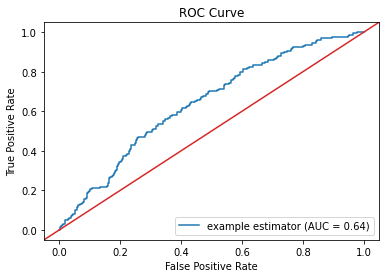

/home/markus/Documents/regression-prediction/experiments/plot_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  print(f'{R.shape=}, {P.shape=}')


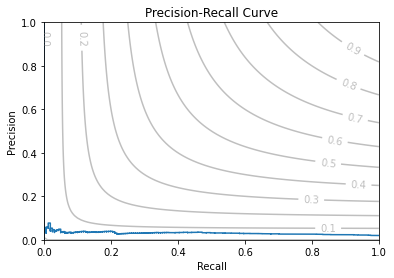

ix_train=array([    0,     1,     2, ..., 21134, 21135, 21136]), ix_val=array([21137, 21138, 21139, ..., 29431, 29432, 29433])
y_train[ix_train].sum()=440, y_train[ix_val].sum()=156
ROC AUC: 0.6418232813331697
AVG PREC: 0.03189253332991124


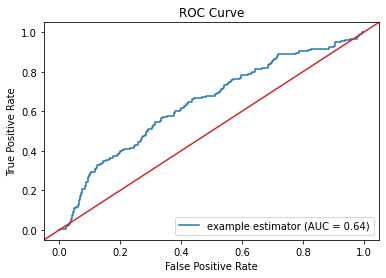

/home/markus/Documents/regression-prediction/experiments/plot_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  print(f'{R.shape=}, {P.shape=}')


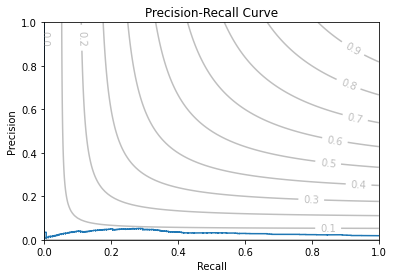

ix_train=array([    0,     1,     2, ..., 29431, 29432, 29433]), ix_val=array([29434, 29435, 29436, ..., 37728, 37729, 37730])
y_train[ix_train].sum()=596, y_train[ix_val].sum()=155
ROC AUC: 0.5811934929200244
AVG PREC: 0.042164310976426436


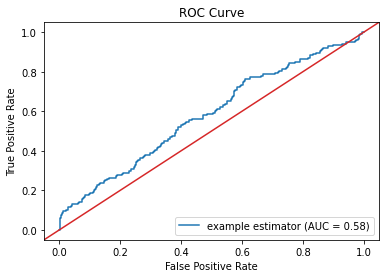

/home/markus/Documents/regression-prediction/experiments/plot_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  print(f'{R.shape=}, {P.shape=}')


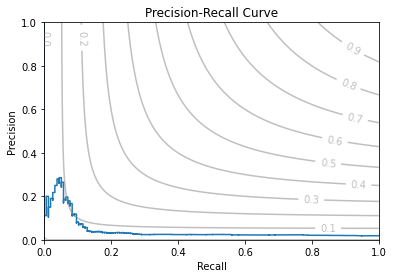

ix_train=array([    0,     1,     2, ..., 37728, 37729, 37730]), ix_val=array([37731, 37732, 37733, ..., 46025, 46026, 46027])
y_train[ix_train].sum()=751, y_train[ix_val].sum()=320
ROC AUC: 0.6989892816848439
AVG PREC: 0.09361129923051995


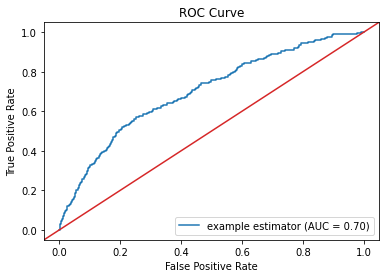

/home/markus/Documents/regression-prediction/experiments/plot_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  print(f'{R.shape=}, {P.shape=}')


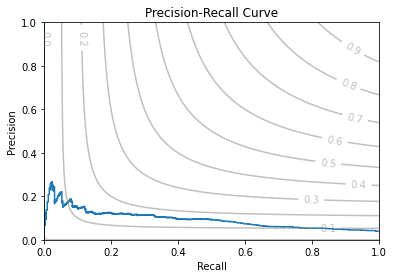

ix_train=array([    0,     1,     2, ..., 46025, 46026, 46027]), ix_val=array([46028, 46029, 46030, ..., 54322, 54323, 54324])
y_train[ix_train].sum()=1071, y_train[ix_val].sum()=200
ROC AUC: 0.6316425836729652
AVG PREC: 0.09210367029028332


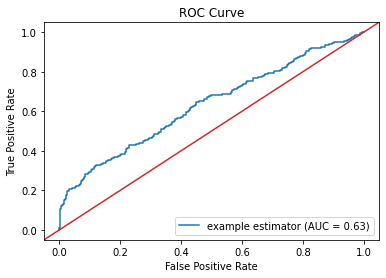

/home/markus/Documents/regression-prediction/experiments/plot_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  print(f'{R.shape=}, {P.shape=}')


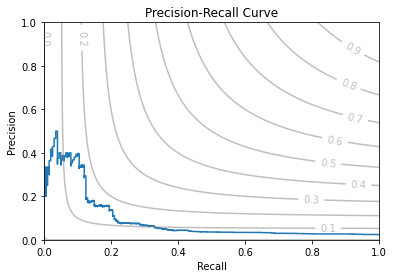

In [207]:
for ix_train, ix_val in tscv.split(X_train, y_train):
    print(f'{ix_train=}, {ix_val=}')
    print(f'{y_train[ix_train].sum()=}, {y_train[ix_val].sum()=}')
    pipeline.fit(X_train[ix_train, :], y_train[ix_train])

    y_score = pipeline.predict_proba(X_train[ix_val, :])[:,1]
    print('ROC AUC:', metrics.roc_auc_score(y_train[ix_val], y_score))
    print('AVG PREC:', metrics.average_precision_score(y_train[ix_val], y_score))
    plot_roc_curve(pipeline, X_train[ix_val, :], y_train[ix_val])
    plot_precision_recall_curve_with_f1(pipeline,  X_train[ix_val, :], y_train[ix_val])

In [227]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sampler', RandomOverSampler(random_state=0)),
                ('model',
                 LogisticRegression(C=0.0585581498080432, penalty='l1',
                                    random_state=0, solver='saga'))])

In [228]:
y_score = pipeline.predict_proba(X_train)[:,1]
metrics.roc_auc_score(y_train, y_score), metrics.average_precision_score(y_train, y_score)

(0.70803021768685, 0.07040226394259014)

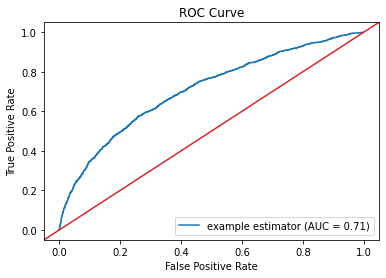

In [229]:
plot_roc_curve(pipeline, X_train, y_train)

best F1: 0.14004796163069544 at precision=0.10072438771990341 recall=0.22974036191974823


/home/markus/Documents/regression-prediction/experiments/plot_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  print(f'{R.shape=}, {P.shape=}')


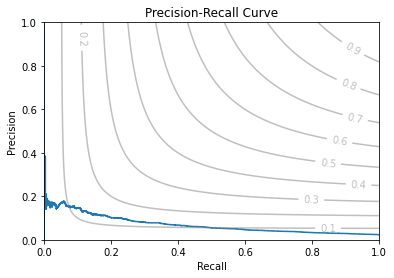

In [230]:
plot_precision_recall_curve_with_f1(pipeline, X_train, y_train)

In [231]:
y_score = pipeline.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_score), metrics.average_precision_score(y_test, y_score)

(0.6972119071340156, 0.08774324151477836)

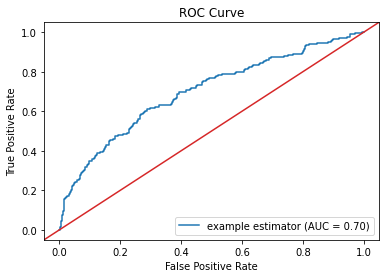

In [232]:
plot_roc_curve(pipeline, X_test, y_test)

best F1: 0.18125 at precision=0.20863309352517986 recall=0.16022099447513813


/home/markus/Documents/regression-prediction/experiments/plot_utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  print(f'{R.shape=}, {P.shape=}')


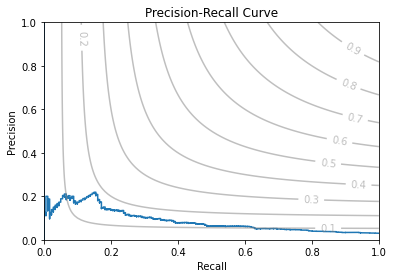

In [233]:
plot_precision_recall_curve_with_f1(pipeline, X_test, y_test)

In [136]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x7f959f821820>,
 'caps': [<matplotlib.lines.Line2D at 0x7f959f821e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f959f821550>],
 'medians': [<matplotlib.lines.Line2D at 0x7f959f8303a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f959f830670>],
 'means': []}

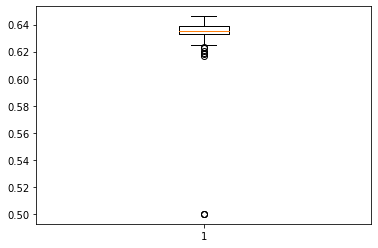

In [19]:
plt.boxplot(results['mean_test_score'])